# GNN for clustering

This notebook trains a GraphSAGE GNN for a link-prediction problem.
Inputs are Pandora 3D clusters that contain more than one true particle contributing a sizeable amount of the total energy.

Nodes correspond to 3D hits, and node features are: x, y, z coordinates and ADC counts.

A positive link should be predicted between any two hits that were contributed most ADC counts by the same true particle.

GraphSAGE paper: https://arxiv.org/abs/1706.02216 

In [86]:
from datetime import datetime
import math
import os.path as osp
import sys
import time
import csv
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GraphSAGE
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import datasets, metrics, model_selection, svm
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

## Functions (shouldn't need to modify these for routine operation)

In [87]:
def normaliseX(xPos):
    xPos = (xPos +350)/100
    return xPos

def normaliseY(yPos):
    yPos = (yPos +650)/100
    return yPos

def normaliseZ(zPos):
    zPos = zPos/100
    return zPos

def normaliseAdc(adcCounts):
    adcCounts=adcCounts/10
    return adcCounts

### This is the function that loops over the input csv file lines.
It calls *process_event* which unpacks each line in the file (each line = 1 cluster = 1 graph) to return an "eventArray" with features, edge labels, edge source and edge destination node IDs. One line = 1 cluster. It passes it each row of the csv file via "data" and also passes empty lists for x, y, z, and adcCounts, which will be filled by it.

In [88]:
def process_file(input_file):
    with open(input_file, 'r') as f:
        num_events = len(f.readlines())
    
    dataset=[]
    xPos=[]
    yPos=[]
    zPos=[]
    adcCounts=[]

    with open(input_file, 'r') as f:
            reader = csv.reader(f)
            for i, row in enumerate(tqdm(reader, desc="Test", miniters=100, total=num_events)):
                data = row[1:]
                #print("row nr. = ",i," -----------------------------------------------------------------")
                
                eventArray=process_event(data, f"{i}", xPos, yPos, zPos, adcCounts)
                
                if(len(eventArray)==0):
                    continue
                features=eventArray[0]
                #print("debug features = ",features)
                edgeStart=eventArray[1]
                edgeEnd=eventArray[2]
                edgeLabel=eventArray[3]
                if len(edgeStart) == 0:
                    continue
                edge_index = torch.tensor([edgeStart, edgeEnd], dtype=torch.long)
                node_features = torch.tensor(features, dtype=torch.float)
                edge_labels = torch.tensor(edgeLabel, dtype=torch.long)
                
                data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_labels)

                #Define and then append subgraph with only positive edges
                subg=filter_by_edge_label(data,1)

                # Print info for debug please...######################
                #print_graph_info(subg)
                #####################################################

                dataset.append(subg)

            if plot_input_distributions is True:
    
                plt.hist(xPos, bins=50, alpha=0.5, color='blue')
                plt.title('xPos')
                plt.xlabel('xPos')
                plt.grid(True)
                plt.show()
    
                plt.hist(yPos, bins=50, alpha=0.5, color='blue')
                plt.title('yPos')
                plt.xlabel('yPos')
                plt.grid(True)
                plt.show()
    
                plt.hist(zPos, bins=50, alpha=0.5, color='blue')
                plt.title('zPos')
                plt.xlabel('zPos')
                plt.grid(True)
                plt.show()
    
                plt.hist(adcCounts, bins=50, alpha=0.5, color='blue')
                plt.title('adcCounts')
                plt.xlabel('adcCounts')
                plt.grid(True)
                plt.show()    
    
    return dataset

In [89]:
def process_event(data, event, xPos, yPos, zPos, adcCounts):
    eventArray=[]
    nh_coords = 5
    n_hits = int(data[0])
    h_start, h_finish = 1, nh_coords * n_hits+1
    length = len(data[h_start:-1]) 
    
    if length != (n_hits * nh_coords):
        print('Missing information in input file')
        print(n_hits, length)
        return
    
    hmc = np.array(data[h_start:h_finish:nh_coords], dtype=int)   #true mc index
    hx = np.array(data[h_start+1:h_finish:nh_coords], dtype=float)  #x coord
    hy = np.array(data[h_start+2:h_finish:nh_coords], dtype=float)  #y coord  
    hz = np.array(data[h_start+3:h_finish:nh_coords], dtype=float)  #z coord
    hadc = np.array(data[h_start+4:h_finish:nh_coords], dtype=float)#adc

    if normalise_positions==True:
        hx=normaliseX(hx)
        hy=normaliseY(hy)
        hz=normaliseZ(hz)
        
    if normalise_adcs==True:  
        hadc=normaliseAdc(hadc)
    
    if (n_hits > n_hits_in_graph_max) or (n_hits < n_hits_in_graph_min):
       return eventArray
    
    features=np.empty((n_hits,5))

    dimension = n_hits*n_hits
    edgeLabel = np.zeros((dimension))
    edgeStart = np.zeros((dimension))
    edgeEnd = np.zeros((dimension))
    index=0

    #Check that not all hits are associated to the same particle! And the second most contributing particle contributes at least minFrac of hits:
    unique_values, counts = np.unique(hmc, return_counts=True)
    if len(unique_values) >= 2:
        sorted_counts = np.sort(counts)  # Sort the counts
        second_most_frequent_count = sorted_counts[-2]  # Get the second highest count
        total_count = np.sum(counts)
        if second_most_frequent_count / total_count < minFrac:
            #print("The second most contributing MC true particle in this cluster contributes less than 30% hits")
            return eventArray
    else:
        print("there is only one MC true particle in this cluster")
        return eventArray
    
    #This double loop is filling node features and edge labels (plus some lists of input coordinates for plotting purposes)
    for hit1 in range(0,n_hits):
        features[hit1,0]=hx[hit1]
        features[hit1,1]=hy[hit1]
        features[hit1,2]=hz[hit1]
        features[hit1,3]=hadc[hit1]
        features[hit1,4]=hmc[hit1]
        xPos.append(features[hit1,0])
        yPos.append(features[hit1,1])
        zPos.append(features[hit1,2])
        adcCounts.append(features[hit1,3])

        for hit2 in range(hit1+1,n_hits):
            dx = hx[hit2] - hx[hit1]
            dy = hy[hit2] - hy[hit1]
            dz = hz[hit2] - hz[hit1]
            dist = np.sqrt(dx**2 + dy**2 + dz**2)
            adc_ratio = max(hadc[hit1], hadc[hit2]) / min(hadc[hit1], hadc[hit2])
            
            if (dist>max_hit_distance_radius):
                continue            

            edgeStart[index]=int(hit1)
            edgeEnd[index]=int(hit2)
            #here I am saving edge label as 1, if the two hits come from the same mc particle, and 0 otherwise:
            if((hit1 != hit2) and (int(hmc[hit1])!=int(hmc[hit2]))):
                edgeLabel[index]=False
                index=index+1
            elif((hit1 != hit2) and (int(hmc[hit1])==int(hmc[hit2]))):
                edgeLabel[index]=True
                index=index+1
    
    #If I have added a max distance radius cut (and regardless, since "dimension" contains double counting), I need to resize the arrays to contain entries for the hits within that range.
    edgeLabel = edgeLabel[:index]
    edgeStart = edgeStart[:index]
    edgeEnd = edgeEnd[:index]
    features = features[:index,:]
    #print("N positive edges = ",np.sum(edgeLabel > 0))
    #print("N negative edges = ",np.sum(edgeLabel == 0))
    #print("index = ",index)    
    
    if edgeLabel[np.where(edgeLabel==False)].size == 0:
        #print("All hits in this graph are connected!!!")
        return eventArray
        
    eventArray=[features,edgeStart,edgeEnd,edgeLabel]
    return eventArray

The function below takes the list of graphs in "dataset" as returned by "process_file", and it splits every graph in it into four subgraphs: having positive train edges, negative train edges, positive test edges, negative test edges. The split is performed based on the "test_train_ratio" config parameter. It happens to be the case that the graphs have more positive edges than negative edges. Negative edges are then augmented, resampling them. 

At the end the graphs are bundled in batches. If you wanted to do a sampling, you could use NeighbourLoader instead of data loader

In [90]:
def prepare_samples_for_training(dataset):
    
    train_data_list=[]
    train_pos_data_list=[]
    train_neg_data_list=[]
    test_pos_data_list=[]
    test_neg_data_list=[]
    
    for data in dataset:
        print("----------------------------------------------------------------------------------------------------------")
        # Split edge set for training and testing
        u = data.edge_index[0]
        v = data.edge_index[1]
        edge_attr = data.edge_attr
        eids = torch.arange(data.num_edges)
        if data.num_edges<10:
            continue
        
        eids = eids[torch.randperm(eids.size(0))]
        test_size = int(len(eids) * test_train_ratio)
        train_size = len(eids) - test_size
        test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
        train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]] 
        
        # Generating negative edges for training and testing
        adj = np.zeros((data.num_nodes, data.num_nodes))
        adj[u, v] = data.edge_attr

        neg_u=[]
        neg_v=[]
        i=0
        j=0
        for ihit in data.x:
            j=0
            for jhit in data.x:
                #print("i = ",i," j = ",j)
                if j>i:
                    dx = jhit[0].item() - ihit[0].item()
                    dy = jhit[1].item() - ihit[1].item()
                    dz = jhit[2].item() - ihit[2].item()
                    dist = np.sqrt(dx**2 + dy**2 + dz**2)
                    if adj[i,j]!=1 and dist<max_hit_distance_radius: #need to specify that it is within radius, otherwise I am labelling as negative some edges that were actually positive but I discarded because of distance
                        neg_u.append(i)
                        neg_v.append(j)
                j=j+1
            i=i+1
        neg_u=np.array(neg_u)    
        neg_v=np.array(neg_v) 
        
        print("data.num_edges = ",data.num_edges)
        print("data.num_nodes = ",data.num_nodes)

        total_neg_edges = len(neg_u)  # Total number of available negative edges
        desired_test_size = int(data.num_edges * test_train_ratio)
        desired_train_size = data.num_edges - desired_test_size

        shuffled_neg_eids = torch.randperm(len(neg_u))

        # Determine the split point for test and train sizes based on test_train_ratio
        split_point = int(len(shuffled_neg_eids) * test_train_ratio)
        
        # Split the shuffled indices into training and testing segments without overlap
        test_neg_indices = shuffled_neg_eids[:split_point]
        train_neg_indices = shuffled_neg_eids[split_point:]

        current_test_size = len(test_neg_indices)
        current_train_size = len(train_neg_indices)
        shortfall_test = desired_test_size - current_test_size
        shortfall_train = desired_train_size - current_train_size

        if shortfall_test > 0:
            additional_test_indices = test_neg_indices[torch.randint(high=len(test_neg_indices), size=(shortfall_test,))]
            test_neg_indices = torch.cat((test_neg_indices, additional_test_indices))

        # Augment train_neg_indices if there's a shortfall
        if shortfall_train > 0:
            additional_train_indices = train_neg_indices[torch.randint(high=len(train_neg_indices), size=(shortfall_train,))]
            train_neg_indices = torch.cat((train_neg_indices, additional_train_indices))

        # Use these indices to get the corresponding negative edges for training and testing
        test_neg_u, test_neg_v = neg_u[test_neg_indices], neg_v[test_neg_indices]
        train_neg_u, train_neg_v = neg_u[train_neg_indices], neg_v[train_neg_indices]

        if(test_neg_u.size>1):
            test_neg_u=torch.tensor(test_neg_u)
            test_neg_v=torch.tensor(test_neg_v)
        else:
            test_neg_u=torch.tensor([test_neg_u])
            test_neg_v=torch.tensor([test_neg_v])
        if(train_neg_u.size>1):
            train_neg_u=torch.tensor(train_neg_u)
            train_neg_v=torch.tensor(train_neg_v)
        else:
            train_neg_u=torch.tensor([train_neg_u])
            train_neg_v=torch.tensor([train_neg_v])
        
        test_pos_edge_index = torch.tensor([test_pos_u.numpy(),test_pos_v.numpy()], dtype=torch.long)
        test_neg_edge_index = torch.tensor([test_neg_u.numpy(),test_neg_v.numpy()], dtype=torch.long)
        train_pos_edge_index = torch.tensor([train_pos_u.numpy(),train_pos_v.numpy()], dtype=torch.long)
        train_neg_edge_index = torch.tensor([train_neg_u.numpy(),train_neg_v.numpy()], dtype=torch.long)

        train_edge_index = torch.cat([train_pos_edge_index, train_neg_edge_index], dim=1)
        test_edge_index = torch.cat([test_pos_edge_index, test_neg_edge_index], dim=1)

        train_data = Data(x=data.x, edge_index=train_edge_index)
    
        train_pos_data_mc = Data(x=data.x, edge_index=train_pos_edge_index)
        train_neg_data_mc = Data(x=data.x, edge_index=train_neg_edge_index)
        test_pos_data_mc = Data(x=data.x, edge_index=test_pos_edge_index)
        test_neg_data_mc = Data(x=data.x, edge_index=test_neg_edge_index)    

        visualise_particle_projections(train_pos_data_mc)     #Showing particle projection plots

        #Now I want to remove the MC truth feature that I just used in the 2D plots, as I dont want to use this in training...
        new_features = data.x[:, :4]
        
        train_pos_data = Data(x=new_features, edge_index=train_pos_edge_index)
        train_neg_data = Data(x=new_features, edge_index=train_neg_edge_index)
        test_pos_data = Data(x=new_features, edge_index=test_pos_edge_index)
        test_neg_data = Data(x=new_features, edge_index=test_neg_edge_index) 

        train_data_list.append(train_data)
        train_pos_data_list.append(train_pos_data)
        train_neg_data_list.append(train_neg_data)
        test_pos_data_list.append(test_pos_data)
        test_neg_data_list.append(test_neg_data)
        

    batchSize=128
    train_data_loader=DataLoader(train_data_list, batch_size=batchSize, shuffle=False)    
    train_pos_data_loader=DataLoader(train_pos_data_list, batch_size=batchSize, shuffle=False) 
    train_neg_data_loader=DataLoader(train_neg_data_list, batch_size=batchSize, shuffle=False) 
    test_pos_data_loader=DataLoader(test_pos_data_list, batch_size=batchSize, shuffle=False) 
    test_neg_data_loader=DataLoader(test_neg_data_list, batch_size=batchSize, shuffle=False) 

    #Redefining train_data, train_pos_data, train_neg_data, test_pos_data, test_neg_data
    train_data=next(iter(train_data_loader))
    train_pos_data=next(iter(train_pos_data_loader))
    train_neg_data=next(iter(train_neg_data_loader))
    test_pos_data=next(iter(test_pos_data_loader))
    test_neg_data=next(iter(test_neg_data_loader))

    # Print train and test sizes ########################
    print("Number of positive train edges: ",train_pos_data.num_edges," nodes: ",train_pos_data.num_nodes)
    print("Number of negative train edges: ",train_neg_data.num_edges," nodes: ",train_neg_data.num_nodes)
    print("Number of positive test edges: ",test_pos_data.num_edges," nodes: ",test_pos_data.num_nodes)
    print("Number of negative test edges: ",test_neg_data.num_edges," nodes: ",test_neg_data.num_nodes)
    #####################################################
    
    return train_data, train_pos_data, train_neg_data, test_pos_data, test_neg_data

In [91]:
def filter_by_edge_label(input_data, edge_label_value):
    edge_attr = input_data.edge_attr
    condition = (edge_attr == edge_label_value).squeeze()

    # Create a subgraph by filtering edges based on the condition
    subgraph_edge_index = input_data.edge_index[:, condition]
    subgraph = Data(x=input_data.x, edge_index=subgraph_edge_index, edge_attr=edge_attr[condition])

    # Get the set of nodes in the original graph and the subgraph
    original_nodes = set(range(input_data.num_nodes))
    subgraph_nodes = set(subgraph.edge_index.flatten().unique().numpy())
    
    # Find isolated nodes (nodes not connected to any edges satisfying the condition)
    isolated_nodes = original_nodes.difference(subgraph_nodes)
    subgraph.x = input_data.x

    return subgraph

In [92]:
def print_graph_info(data):
    # Expand the tensor printing
    torch.set_printoptions(threshold=5000)

    print("data.num_nodes = ", data.num_nodes)
    print("data.num_edges = ", data.num_edges)
    # Number of node features
    print("data.x = ",data.x)
    # Get the edge attributes from the input graph
    edge_attributes = data.edge_attr
    # Count the number of edges with positive values
    num_positive_edges = torch.sum(edge_attributes > 0).item()
    num_negative_edges = torch.sum(edge_attributes < 1).item()
    print("Number of edges with label 1:", num_positive_edges)
    print("Number of edges with label 0:", num_negative_edges)
    

In [93]:
def compute_loss(pos_score, neg_score):

    #print("pos_score = ", pos_score)
    #print("neg_score = ", neg_score)
    
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])

    loss_function = nn.BCELoss()
    
    return loss_function(scores, labels)

In [94]:
def calculate_accuracy(pos_test_score, neg_test_score):
    scores = torch.cat([pos_test_score, neg_test_score])
    labels = torch.cat([torch.ones(pos_test_score.shape[0]), torch.zeros(neg_test_score.shape[0])])
    true_labels = labels.numpy()

    thresholds = torch.arange(0.05, 1.0, 0.05)
    predictions = []
    accuracy = []

    for threshold in thresholds:
        prediction = (scores >= threshold).float()
        accuracy.append(accuracy_score(true_labels, prediction.numpy()))
        predictions.append(prediction)

    max_accuracy = torch.max(torch.tensor(accuracy))
    max_accuracy_index = torch.argmax(torch.tensor(accuracy))
    optimal_threshold = thresholds[max_accuracy_index].item()

    return optimal_threshold, max_accuracy

In [95]:
def show_confusion_matrix(pos_test_score, neg_test_score, threshold):
    scores = torch.cat([pos_test_score, neg_test_score])
    labels = torch.cat([torch.ones(pos_test_score.shape[0]), torch.zeros(neg_test_score.shape[0])])
    probabilities=scores
    predictions = (probabilities >= threshold).float()
    true_labels = labels.numpy()
    predicted_labels =predictions.numpy()

    fpr, tpr, thresholds = metrics.roc_curve(true_labels, probabilities.numpy())
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
    display.plot()
    plt.show()
    cm = confusion_matrix(true_labels, predicted_labels)

    sns.set(style="whitegrid", palette="pastel")
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])
        
    plt.show()

In [96]:
def plot_scores(pos_test_score, neg_test_score,train_or_test):
    #print(f'Number of entries in pos_test_score: {len(pos_test_score)}')
    #print(f'Number of entries in neg_test_score: {len(neg_test_score)}')
    plt.hist(pos_test_score.numpy(), bins=100, range=(0, 1.1), alpha=0.3, color='blue', edgecolor='black', label='pos_test_score')
    plt.hist(neg_test_score.numpy(), bins=100, range=(0, 1.1), alpha=0.3, color='red', edgecolor='black', label='neg_test_score')

    plt.yscale('log')
    plt.title(train_or_test)
    plt.legend()
    plt.show()

In [97]:
def plot_loss_evolution(epochs, training_loss, test_loss, accuracy, ylim1, ylim2):
    fig, ax1 = plt.subplots()

    ax1.plot(epochs, training_loss, label='Training Loss', color='b')
    ax1.plot(epochs, test_loss, label='Validation Loss', color='g')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='upper left')
    ax1.set_title('Training and Validation Loss Over Epochs')

    ax2 = ax1.twinx()
    ax2.plot(epochs, accuracy, label='Accuracy', color='r')
    ax2.set_ylabel('Accuracy Scale', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper right')

    if ylim1 > 0:
        ax1.set_ylim(0.0001, ylim1)
    if ylim2 > 0:
        ax2.set_ylim(0.0001, ylim2)
    ax1.set_yscale('log')

    plt.draw()
    plt.show()

In [98]:
def visualise_particle_projections(data):
    x = data.x[:,0]
    y = data.x[:,1]
    z = data.x[:,2]
    adc = data.x[:,3]
    mc = data.x[:,4]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    unique_elements, counts = np.unique(mc.numpy(), return_counts=True)
    #print("mc particles in this shower = ", unique_elements, " and their occurrences = ", counts)
    
    axes[0].scatter(x, y, c=mc, cmap='tab20')
    axes[0].set_title("X-Y Plot")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")

    # x-z plot
    axes[1].scatter(x, z, c=mc, cmap='tab20')
    axes[1].set_title("X-Z Plot")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Z")

    # y-z plot
    axes[2].scatter(y, z, c=mc, cmap='tab20')
    axes[2].set_title("Y-Z Plot")
    axes[2].set_xlabel("Y")
    axes[2].set_ylabel("Z")
            
    plt.tight_layout()
    plt.show()

In [99]:
class Predictor(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Predictor, self).__init__()
        self.fc = torch.nn.Linear(2*hidden_channels, 1)  # Concatenated embeddings

    def forward(self, x):
        x = self.fc(x)
        return torch.sigmoid(x)

In [100]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.max_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = float(0)

    def early_stop(self, validation_accuracy):
        print("validation_accuracy = ",validation_accuracy, "self.max_validation_accuracy = ",self.max_validation_accuracy, "self.max_validation_accuracy - self.max_delta = ",self.max_validation_accuracy - self.max_delta)
        if validation_accuracy > self.max_validation_accuracy:
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        elif validation_accuracy < (self.max_validation_accuracy - self.max_delta):
            self.counter += 1
            if self.counter <= self.patience:
                return True
        return False

In [101]:
early_stopper = EarlyStopper(patience=3, min_delta=0.03)
def train_gnn(train_data, train_pos_data, train_neg_data, test_pos_data, test_neg_data):
    
    training_loss = []
    test_loss = []
    accuracy = []
    
    device = torch.device("cpu")
    
    # This is using the pyg own module ##################
    GraphSAGE_model = GraphSAGE(
        train_data.num_node_features,
        hidden_channels=model_hidden_channels,
        num_layers=model_num_layers,
    ).to(device)

    Predictor_model = Predictor(
        hidden_channels=model_hidden_channels
    ).to(device)

    # # ----------- 3. set up loss and optimizer -------------- #
    model_parameters = list(GraphSAGE_model.parameters()) + list(Predictor_model.parameters())
    optimizer = torch.optim.Adam(model_parameters, lr=learning_rate)
    
    # # ----------- 4. training -------------------------------- #
    all_logits = []
    last_epoch=0
    for e in epochs:
         # forward
        GraphSAGE_model.train()
        Predictor_model.train()
    
        optimizer.zero_grad()

        # Generate node embeddings
        h = GraphSAGE_model(train_data.x, train_data.edge_index)
    
        # For each edge, concatenate embeddings of source and destination
        h_pos_edges = torch.cat((h[train_pos_data.edge_index[0]], h[train_pos_data.edge_index[1]]), dim=-1)
        h_neg_edges = torch.cat((h[train_neg_data.edge_index[0]], h[train_neg_data.edge_index[1]]), dim=-1)
        
        # Predictions
        pos_pred = Predictor_model(h_pos_edges).squeeze()
        neg_pred = Predictor_model(h_neg_edges).squeeze()
    
        # Calculate loss
        loss = compute_loss(pos_pred, neg_pred)

        loss.backward()
        optimizer.step()

        #Current test sample loss for this epoch
        with torch.no_grad():
            GraphSAGE_model.eval()
            Predictor_model.eval()
    
            # For each edge, concatenate embeddings of source and destination
            h_pos_test_edges = torch.cat((h[test_pos_data.edge_index[0]], h[test_pos_data.edge_index[1]]), dim=-1)
            h_neg_test_edges = torch.cat((h[test_neg_data.edge_index[0]], h[test_neg_data.edge_index[1]]), dim=-1)
        
            # Predictions
            pos_test_pred = Predictor_model(h_pos_test_edges).squeeze()
            neg_test_pred = Predictor_model(h_neg_test_edges).squeeze()
    
            # Calculate loss
            testloss = compute_loss(pos_test_pred, neg_test_pred)
        
        trainingloss = loss

        optimal_threshold, maximum_accuracy=calculate_accuracy(pos_test_pred, neg_test_pred)           

        training_loss.append(trainingloss.detach().numpy())
        test_loss.append(testloss)
        accuracy.append(maximum_accuracy)
        
        if e%5 == 0:
            print('======> In epoch {}, training loss: {}, test loss: {}'.format(e, trainingloss, testloss))
            print("optimal threshold = ",optimal_threshold," maximum_accuracy = ",maximum_accuracy)
            plot_scores(pos_pred.detach(), neg_pred.detach(), "train")
            plot_scores(pos_test_pred, neg_test_pred, "test")
        
        last_epoch=e
        if e>50 and early_stopper.early_stop(maximum_accuracy.item()):     
            break

    plot_loss_evolution(range(0,last_epoch),training_loss,test_loss,accuracy,-999,-999)
    show_confusion_matrix(pos_test_pred,neg_test_pred, optimal_threshold)

    now = datetime.now()  # Current date and time
    date_time = now.strftime("%Y-%m-%d_%H-%M-%S")  # Format as a string

    base_filename_graphsage = 'GraphSAGE_model'
    base_filename_predictor = 'Predictor_model'

    graphsage_output_filename = f'{base_filename_graphsage}_{date_time}.pt'
    predictor_output_filename = f'{base_filename_predictor}_{date_time}.pt'

    GraphSAGE_model_jit = torch.jit.script(GraphSAGE_model.jittable())
    Predictor_model_jit = torch.jit.script(Predictor_model)
    GraphSAGE_model_jit.save(graphsage_output_filename)
    Predictor_model_jit.save(predictor_output_filename)
    
    return GraphSAGE_model, Predictor_model 

## Run the GNN! (Here are the commands to prepare samples and run the training)

### Parameters (modify based on your needs!):
**prepare_samples** : if the sample is already loaded in memory in the notebook, I don't want to accidentally re-prepare it (as it's time consuming), so I check this condition later in the notebook when I call prepare_samples_for_training

**n_hits_in_graph_min, n_hits_in_graph_max** : minimum and maximum number of hits for cluster to be in input sample for training

**minFrac** : fraction of hits in the cluster that are contributed by the *second* most contributing MC particle. I want there to be at least a couple of showers both contributing a significant fraction of energy. This is to avoid selecting clusters where only one particle makes almost all of the hits, and then there is only a handful of hits from other particles.

**test_train_ratio**, **epochs**, **learning rate** should self-describe.

***model_hidden_channels*** : the dimensionality of the hidden feature space in the GraphSAGE model

***model_num_layers*** : number of message-passing layers in the GraphSAGE model

***normalise_adcs***,***normalise_positions*** : bringing inputs down to a "small number" range. not normalised between 0 and 1, but numbers are broadly in the 1-10 range.

***plot_input_distributions*** : if true, plot input node feature distributions (i.e. x,y,z,adc) plus some other 

***max_hit_distance_radius*** : in this edge-prediction problem, only create an edge (regardless of if positive or negative) for hits that are less than this amount apart. Units change based on normalisation.


In [102]:
#Parameters
prepare_samples=True

n_hits_in_graph_min=400
n_hits_in_graph_max=700
minFrac=0.3

test_train_ratio=0.1
epochs = range(1, 100)  
learning_rate=0.01
model_hidden_channels=16
model_num_layers=10

normalise_adcs=True
normalise_positions=True

plot_input_distributions=True

if normalise_positions:
    max_hit_distance_radius=0.1 #m 
else:
    max_hit_distance_radius=10 #cm

Test:  33%|█████████████████████████████████▌                                                                   | 100/301 [00:02<00:04, 44.63it/s]/var/folders/xm/zlnnn9n14wz3byvtk649t76h0000gn/T/ipykernel_5613/1485721972.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([edgeStart, edgeEnd], dtype=torch.long)
Test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:12<00:00, 24.42it/s]


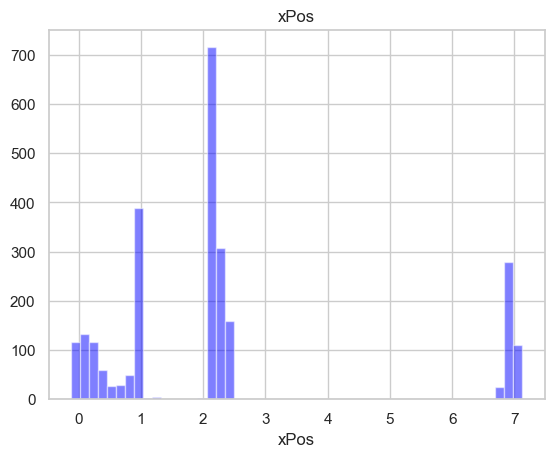

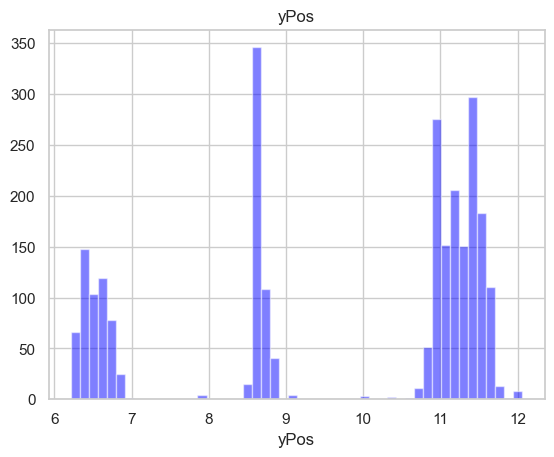

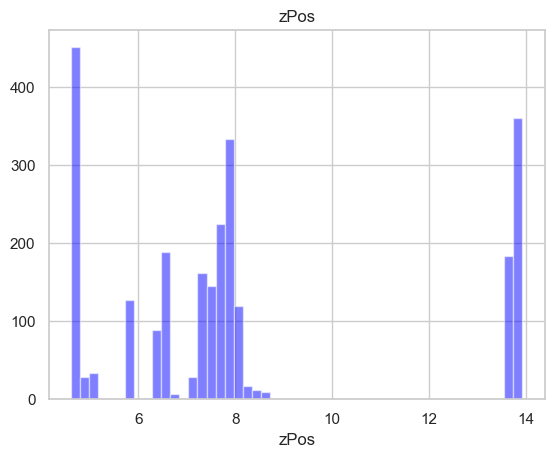

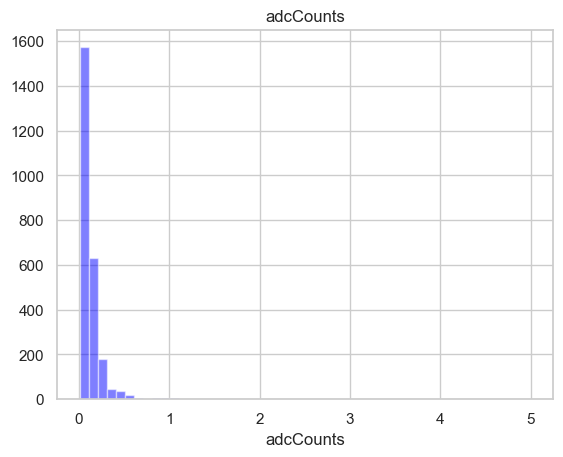

----------------------------------------------------------------------------------------------------------
data.num_edges =  18239
data.num_nodes =  514


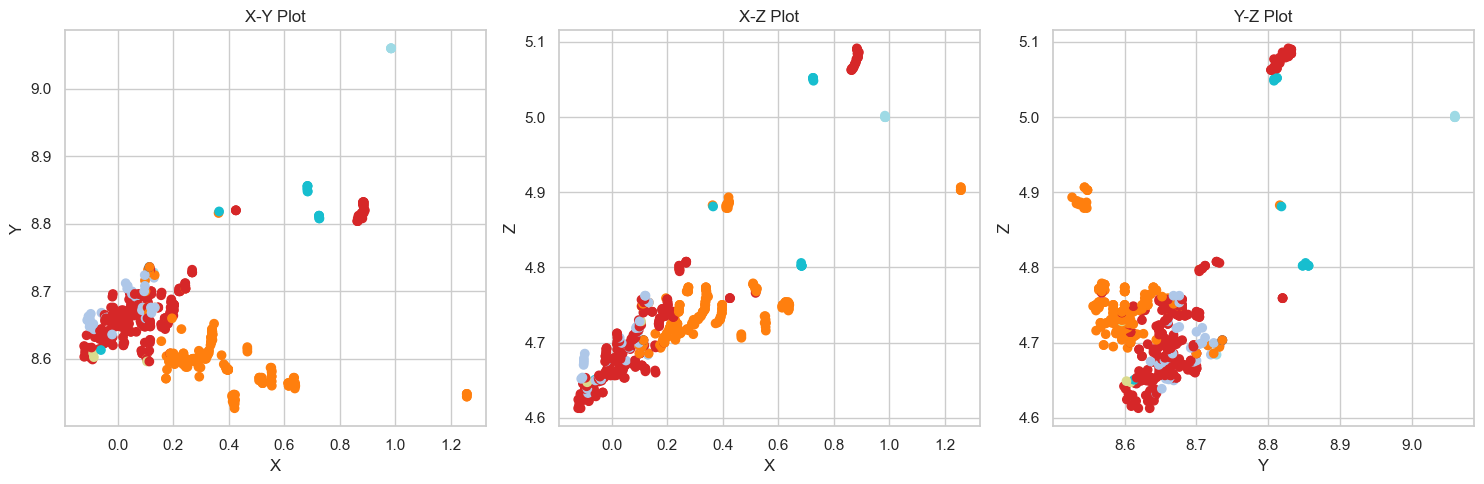

----------------------------------------------------------------------------------------------------------
data.num_edges =  20456
data.num_nodes =  544


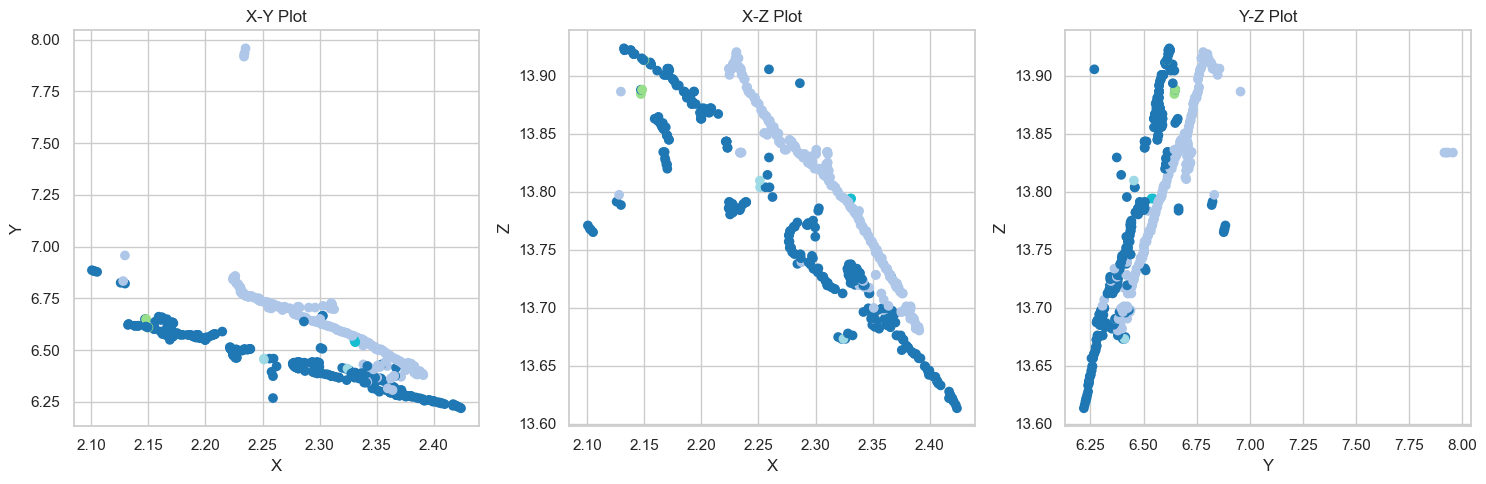

----------------------------------------------------------------------------------------------------------
data.num_edges =  12947
data.num_nodes =  411


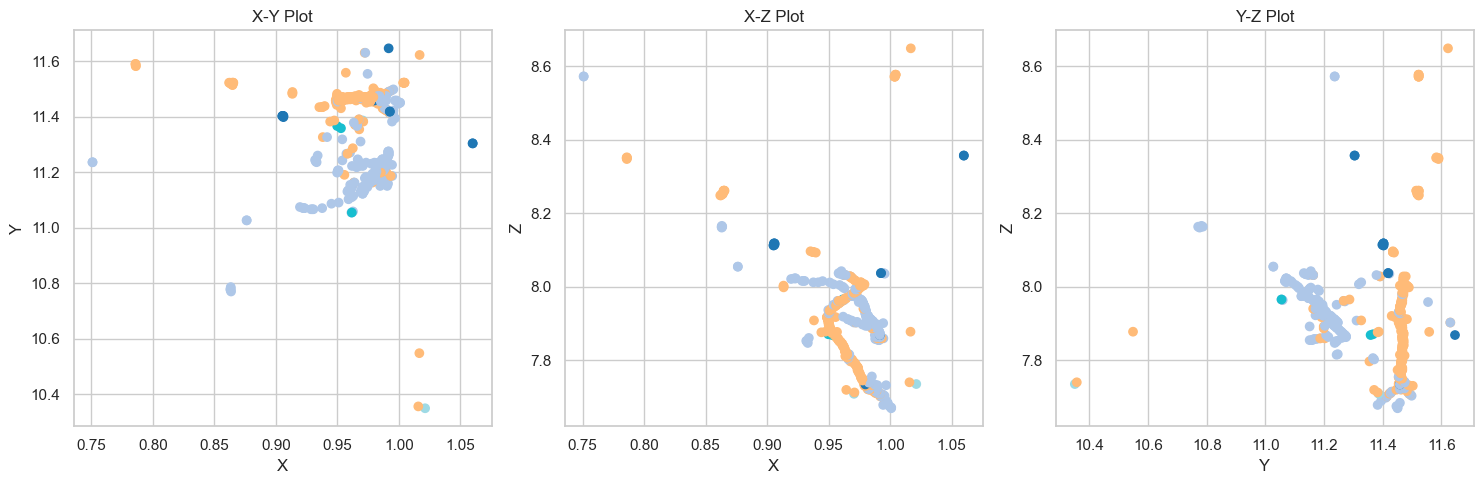

----------------------------------------------------------------------------------------------------------
data.num_edges =  18881
data.num_nodes =  640


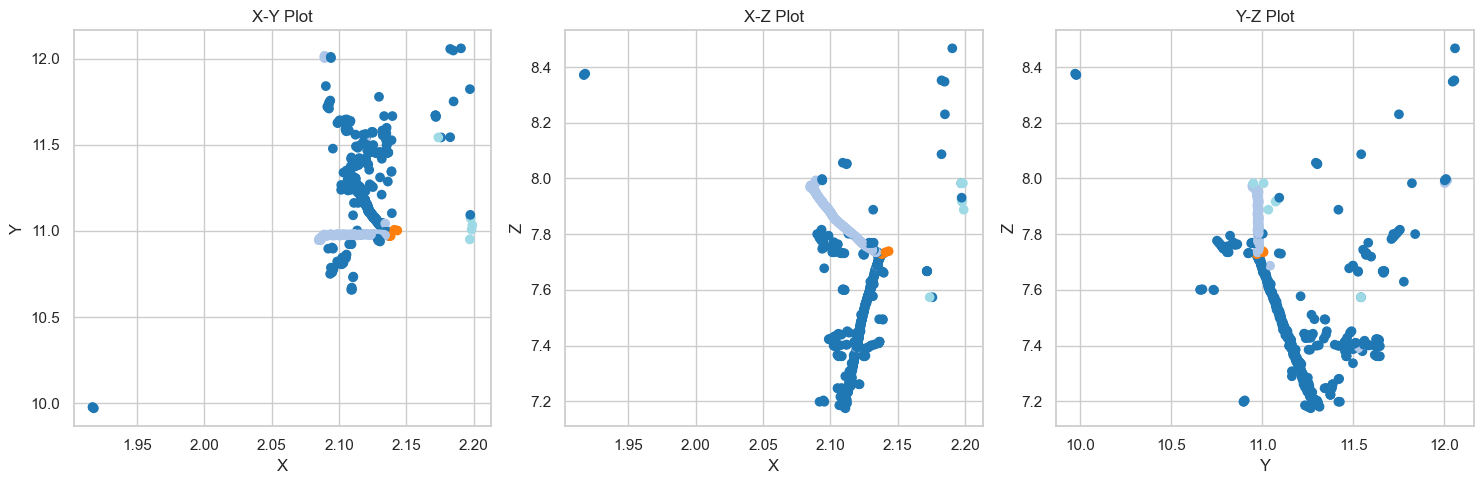

Number of positive train edges:  63473  nodes:  2109
Number of negative train edges:  63473  nodes:  2109
Number of positive test edges:  7050  nodes:  2109
Number of negative test edges:  7050  nodes:  2109


In [103]:
if prepare_samples:
    file_path = f"training_out_test_1000events.csv"
    output_directory = f"outputDir"
    dataset=process_file(file_path)
    train_data, train_pos_data, train_neg_data, test_pos_data, test_neg_data = prepare_samples_for_training(dataset)

======> In epoch 5, training loss: 0.6927408576011658, test loss: 0.6927380561828613
optimal threshold =  0.5  maximum_accuracy =  tensor(0.5001, dtype=torch.float64)


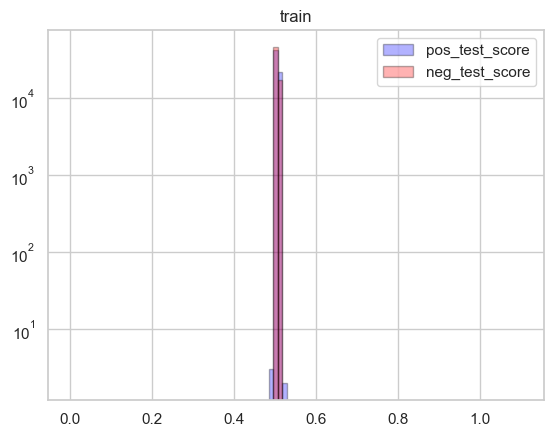

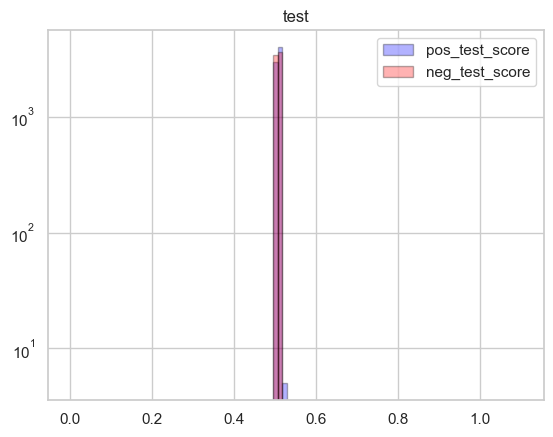

======> In epoch 10, training loss: 0.6771873831748962, test loss: 0.674820601940155
optimal threshold =  0.5  maximum_accuracy =  tensor(0.5884, dtype=torch.float64)


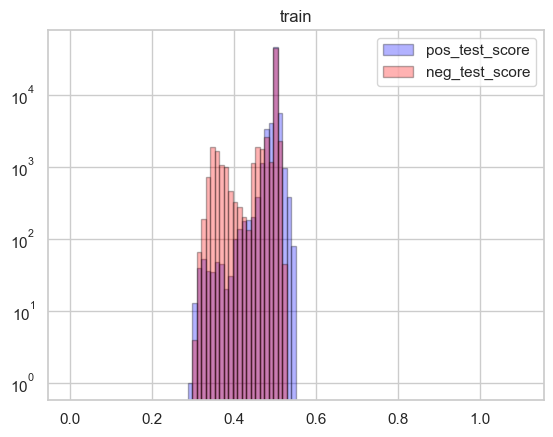

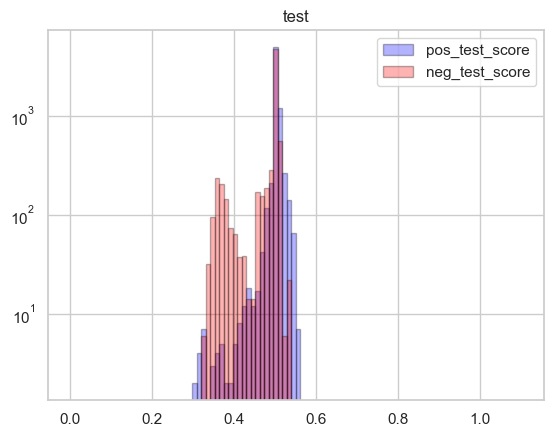

======> In epoch 15, training loss: 0.6462315917015076, test loss: 0.6378794312477112
optimal threshold =  0.5  maximum_accuracy =  tensor(0.6587, dtype=torch.float64)


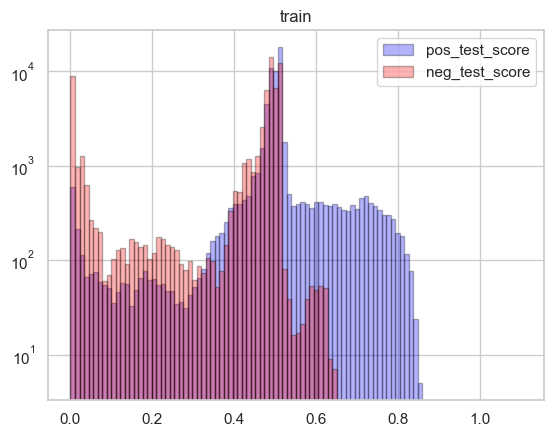

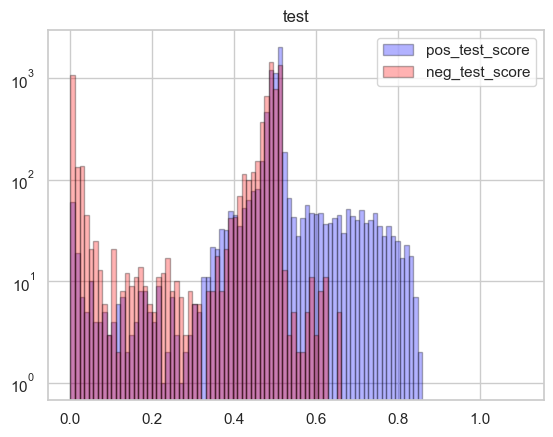

======> In epoch 20, training loss: 0.5982741713523865, test loss: 0.590249240398407
optimal threshold =  0.550000011920929  maximum_accuracy =  tensor(0.6804, dtype=torch.float64)


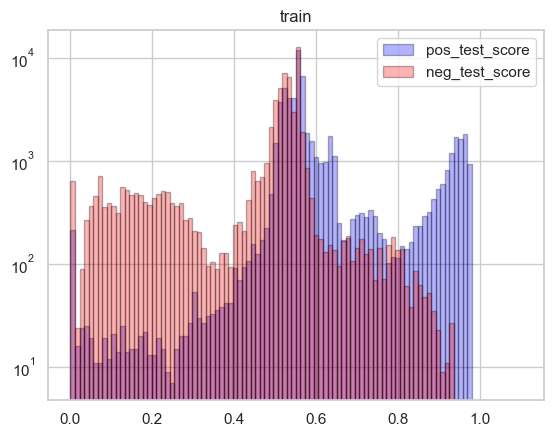

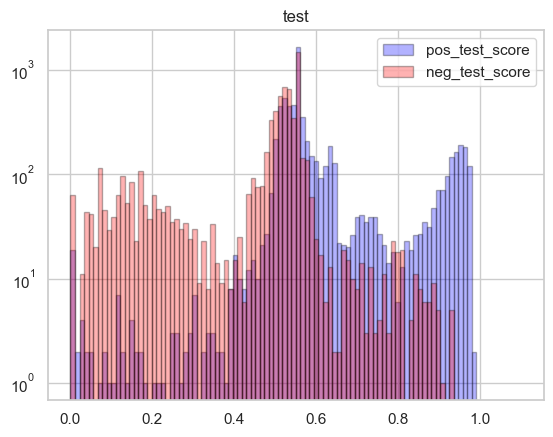

======> In epoch 25, training loss: 0.5695728063583374, test loss: 0.5615758895874023
optimal threshold =  0.4000000059604645  maximum_accuracy =  tensor(0.6955, dtype=torch.float64)


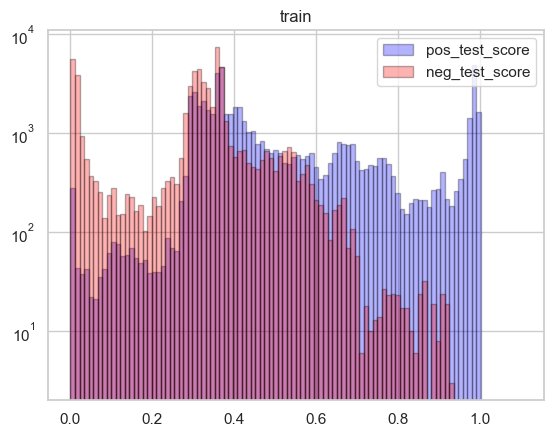

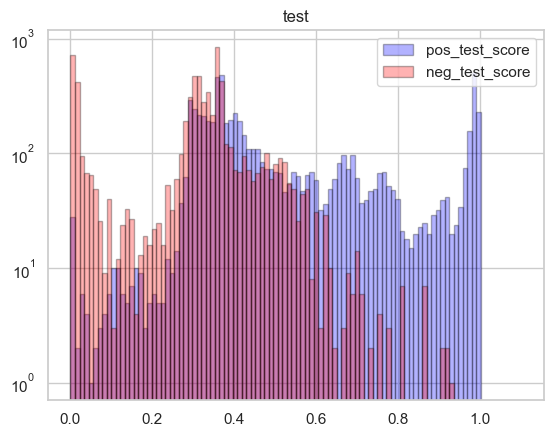

======> In epoch 30, training loss: 0.5471506118774414, test loss: 0.5530344843864441
optimal threshold =  0.44999998807907104  maximum_accuracy =  tensor(0.7071, dtype=torch.float64)


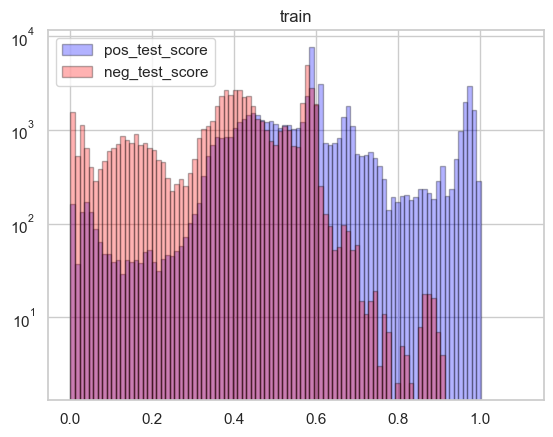

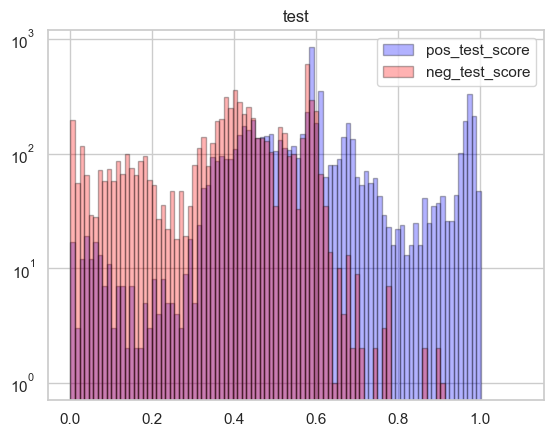

======> In epoch 35, training loss: 0.5159772634506226, test loss: 0.5132014155387878
optimal threshold =  0.4000000059604645  maximum_accuracy =  tensor(0.7439, dtype=torch.float64)


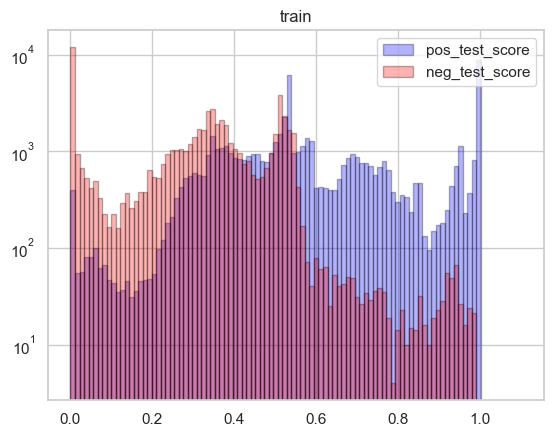

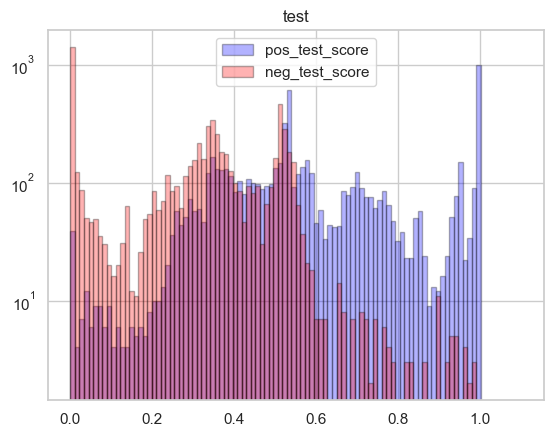

======> In epoch 40, training loss: 0.4876089096069336, test loss: 0.48994356393814087
optimal threshold =  0.550000011920929  maximum_accuracy =  tensor(0.7852, dtype=torch.float64)


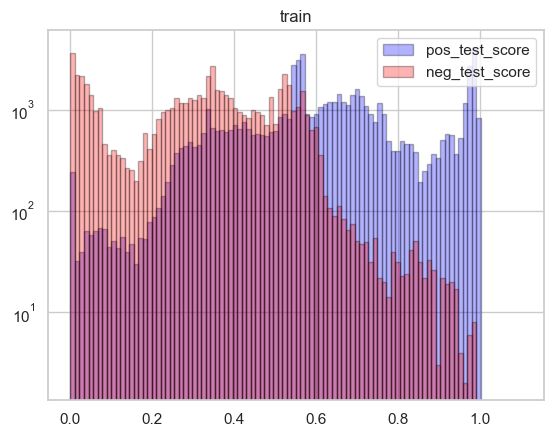

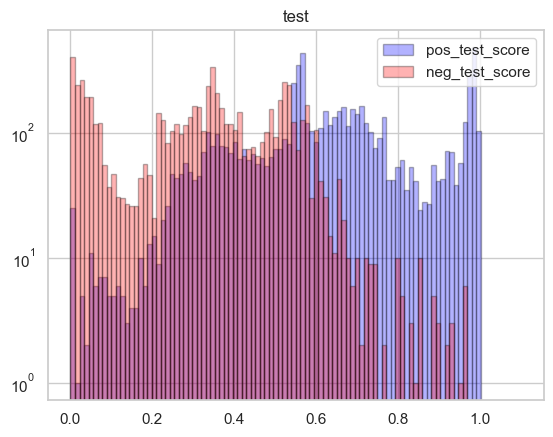

======> In epoch 45, training loss: 0.4654918611049652, test loss: 0.4669429361820221
optimal threshold =  0.5999999642372131  maximum_accuracy =  tensor(0.7789, dtype=torch.float64)


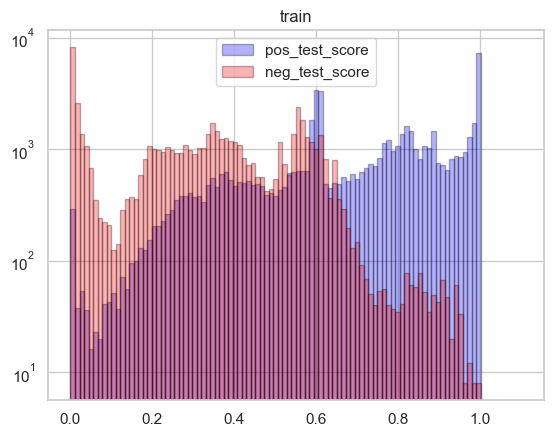

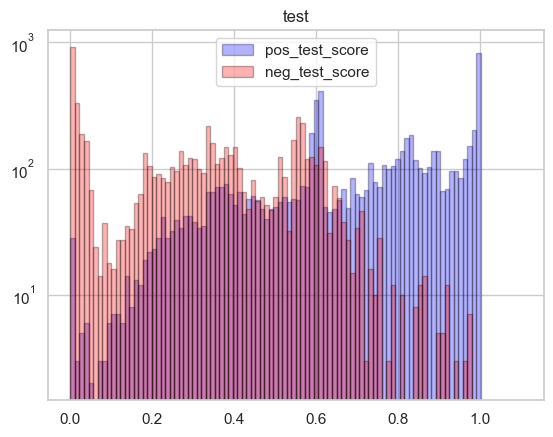

======> In epoch 50, training loss: 0.45551198720932007, test loss: 0.45900896191596985
optimal threshold =  0.5999999642372131  maximum_accuracy =  tensor(0.8024, dtype=torch.float64)


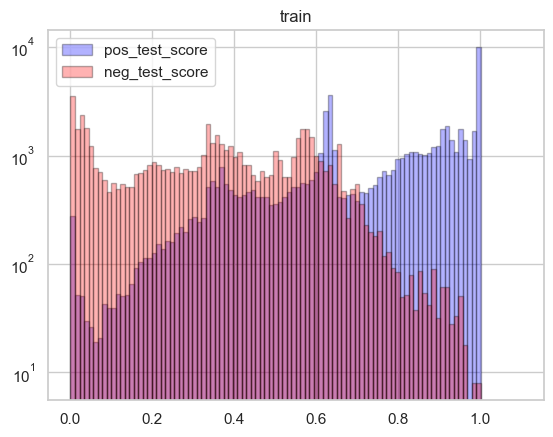

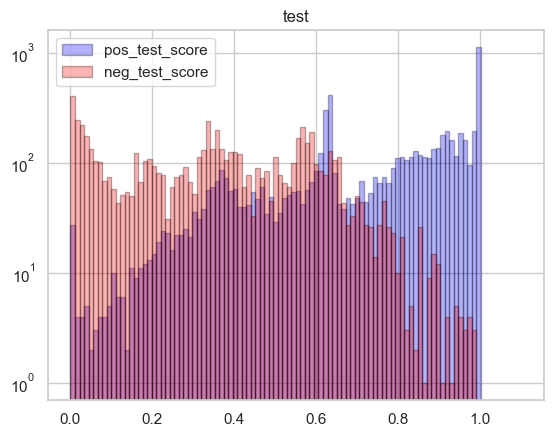

validation_accuracy =  0.8094326241134752 self.max_validation_accuracy =  0.0 self.max_validation_accuracy - self.max_delta =  -0.03
validation_accuracy =  0.8087943262411348 self.max_validation_accuracy =  0.8094326241134752 self.max_validation_accuracy - self.max_delta =  0.7794326241134751
validation_accuracy =  0.7965248226950354 self.max_validation_accuracy =  0.8094326241134752 self.max_validation_accuracy - self.max_delta =  0.7794326241134751
validation_accuracy =  0.8013475177304965 self.max_validation_accuracy =  0.8094326241134752 self.max_validation_accuracy - self.max_delta =  0.7794326241134751
======> In epoch 55, training loss: 0.42975950241088867, test loss: 0.43383467197418213
optimal threshold =  0.5  maximum_accuracy =  tensor(0.8087, dtype=torch.float64)


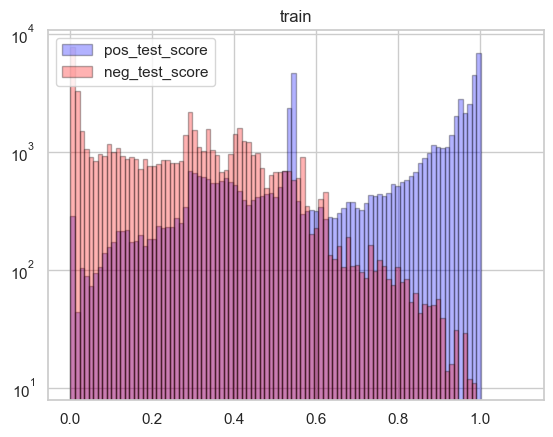

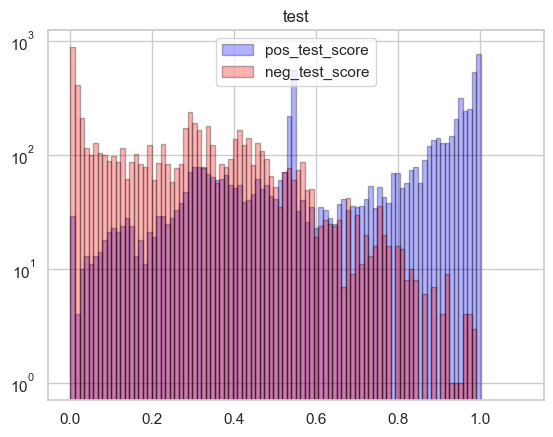

validation_accuracy =  0.8087234042553192 self.max_validation_accuracy =  0.8094326241134752 self.max_validation_accuracy - self.max_delta =  0.7794326241134751
validation_accuracy =  0.815531914893617 self.max_validation_accuracy =  0.8094326241134752 self.max_validation_accuracy - self.max_delta =  0.7794326241134751
validation_accuracy =  0.8102127659574468 self.max_validation_accuracy =  0.815531914893617 self.max_validation_accuracy - self.max_delta =  0.785531914893617
validation_accuracy =  0.8019148936170213 self.max_validation_accuracy =  0.815531914893617 self.max_validation_accuracy - self.max_delta =  0.785531914893617
validation_accuracy =  0.795177304964539 self.max_validation_accuracy =  0.815531914893617 self.max_validation_accuracy - self.max_delta =  0.785531914893617
======> In epoch 60, training loss: 0.4176640808582306, test loss: 0.4232165515422821
optimal threshold =  0.5  maximum_accuracy =  tensor(0.8067, dtype=torch.float64)


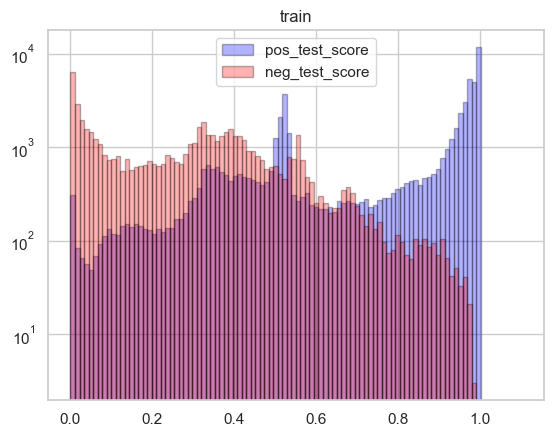

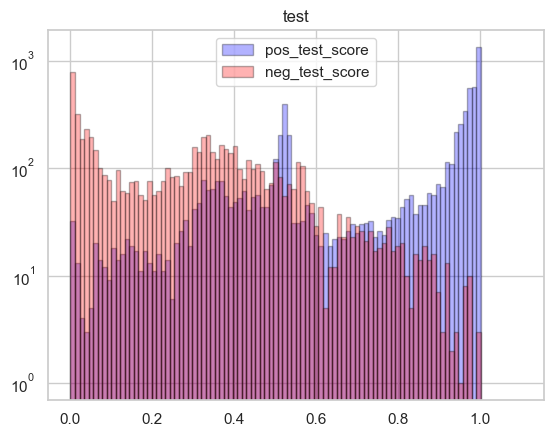

validation_accuracy =  0.8067375886524822 self.max_validation_accuracy =  0.815531914893617 self.max_validation_accuracy - self.max_delta =  0.785531914893617
validation_accuracy =  0.8180851063829787 self.max_validation_accuracy =  0.815531914893617 self.max_validation_accuracy - self.max_delta =  0.785531914893617
validation_accuracy =  0.8112765957446808 self.max_validation_accuracy =  0.8180851063829787 self.max_validation_accuracy - self.max_delta =  0.7880851063829787
validation_accuracy =  0.8217021276595745 self.max_validation_accuracy =  0.8180851063829787 self.max_validation_accuracy - self.max_delta =  0.7880851063829787
validation_accuracy =  0.8212056737588652 self.max_validation_accuracy =  0.8217021276595745 self.max_validation_accuracy - self.max_delta =  0.7917021276595745
======> In epoch 65, training loss: 0.3980320394039154, test loss: 0.40747740864753723
optimal threshold =  0.44999998807907104  maximum_accuracy =  tensor(0.8239, dtype=torch.float64)


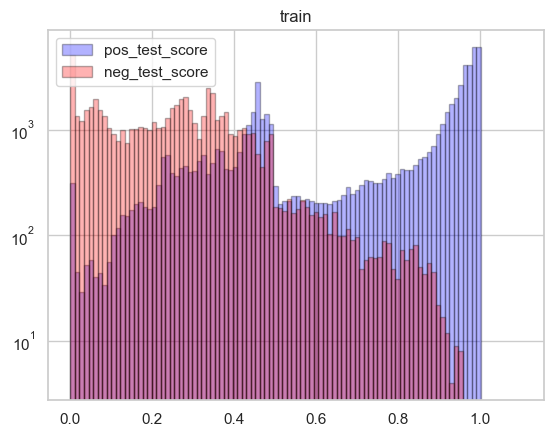

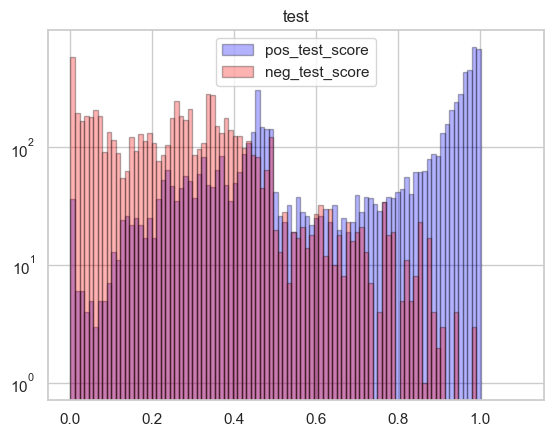

validation_accuracy =  0.8239007092198581 self.max_validation_accuracy =  0.8217021276595745 self.max_validation_accuracy - self.max_delta =  0.7917021276595745
validation_accuracy =  0.8386524822695035 self.max_validation_accuracy =  0.8239007092198581 self.max_validation_accuracy - self.max_delta =  0.7939007092198581
validation_accuracy =  0.8414893617021276 self.max_validation_accuracy =  0.8386524822695035 self.max_validation_accuracy - self.max_delta =  0.8086524822695035
validation_accuracy =  0.847872340425532 self.max_validation_accuracy =  0.8414893617021276 self.max_validation_accuracy - self.max_delta =  0.8114893617021276
validation_accuracy =  0.8257446808510638 self.max_validation_accuracy =  0.847872340425532 self.max_validation_accuracy - self.max_delta =  0.8178723404255319
======> In epoch 70, training loss: 0.49619168043136597, test loss: 0.49571242928504944
optimal threshold =  0.8999999761581421  maximum_accuracy =  tensor(0.8153, dtype=torch.float64)


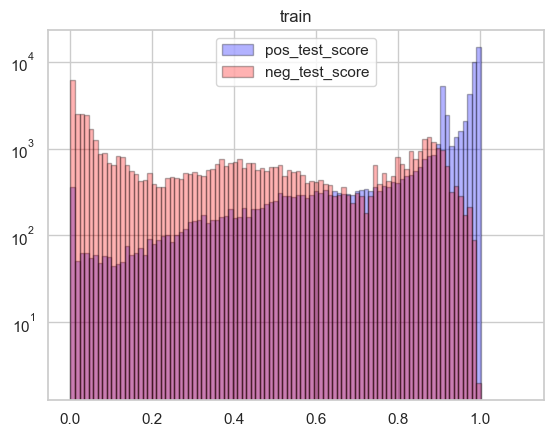

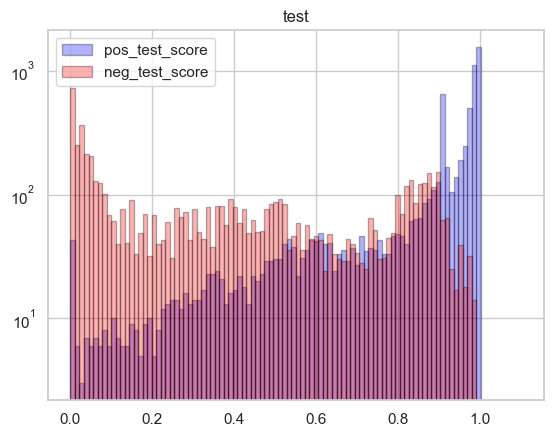

validation_accuracy =  0.8153191489361702 self.max_validation_accuracy =  0.847872340425532 self.max_validation_accuracy - self.max_delta =  0.8178723404255319


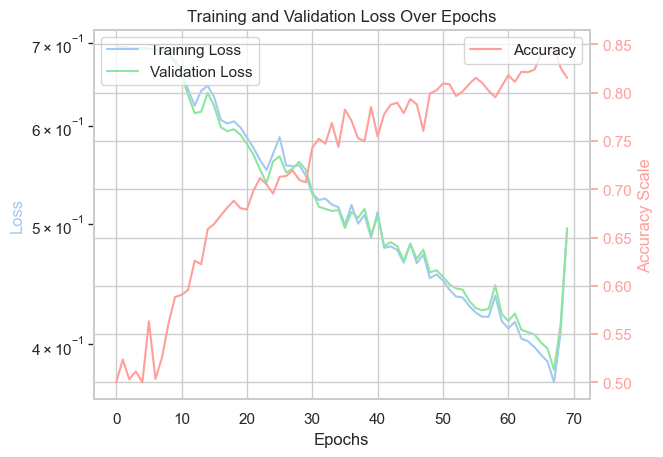

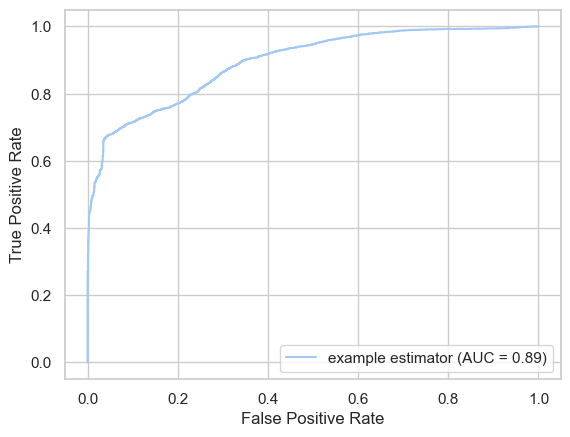

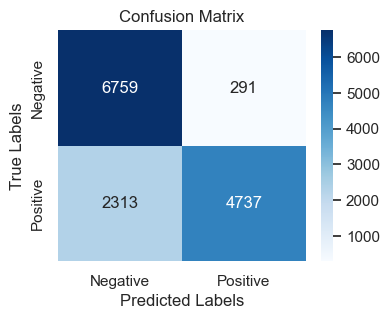

In [104]:
GraphSAGE_model, Predictor_model=train_gnn(train_data, train_pos_data, train_neg_data, test_pos_data, test_neg_data)

This isn't currently used in this example notebook, but you may find it useful e.g. if you want to assess network performance separately from training, or if you add post-processing steps:

In [ ]:
#if I need to reload the model that was already saved:
GraphSAGE_model_new=torch.load("GraphSAGE_model_2024-03-07_01-02-39_10layers_10cm_89percent.pt")
GraphSAGE_model_new.eval()
Predictor_model_new=torch.load("Predictor_model_2024-03-07_01-02-39_10layers_10cm_89percent.pt")
Predictor_model_new.eval()